# Natural Language Processing
## Assignment - 2
### Group Members
1. Donal Loitam (AI21BTECH11009)
2. Sai Pradeep (AI21BTECH11013)
3. Suraj Kumar (AI21BTECH11029)

In [12]:
!pip install pandas numpy matplotlib seaborn nltk scikit-learn torch


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


In [2]:
# Download stopwords if not already available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ai21btech11012/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# DATASET 1

## Data Understanding

In [3]:
!pip install openpyxl

In [4]:
file_path = 'sample_data/Dataset-1.xlsx'
df = pd.read_excel(file_path)
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [5]:
print(df.columns)

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')


In [6]:
# Check for missing values,  class imbalance, and other issues.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB
None


## Data Preprocessing
1. Define a function for processing text
2. Create labels and convert labels into a binary multi-label format
3. Split data into train-test sets

In [7]:
def process_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    new_processed_text = ' '.join(words)
    return new_processed_text

In [8]:
# Apply this function to title and abstract columns of the df
df['processed_title'] = df['TITLE'].apply(process_text)
df['processed_abstract'] = df['ABSTRACT'].apply(process_text)

# Merge these columns into one
df['processed_text'] = df['processed_title'] + ' ' + df['processed_abstract']
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,processed_title,processed_abstract,processed_text
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,reconstructing subjectspecific effect maps,predictive models allow subjectspecific infere...,reconstructing subjectspecific effect maps pre...
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,rotation invariance neural network,rotation invariance translation invariance gre...,rotation invariance neural network rotation in...
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,spherical polyharmonics poisson kernels polyha...,introduce develop notion spherical polyharmoni...,spherical polyharmonics poisson kernels polyha...
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,finite element approximation stochastic maxwel...,stochastic landaulifshitzgilbert llg equation ...,finite element approximation stochastic maxwel...
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,comparative study discrete wavelet transforms ...,fouriertransform infrared ftir spectra samples...,comparative study discrete wavelet transforms ...


In [9]:
# Columns 3 to 8 are labels, so extract these column names and store it in a list
label_columns = df.columns[3:9]
print(label_columns)

# Prepare Labels (Multi-label classification)
df["labels"] = df[label_columns].apply(lambda x: list(np.where(x == 1)[0]), axis=1)

# Convert multi-labels into binary format
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["labels"])

Index(['Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')


In [10]:
# Check for class imbalance
label_counts = df[label_columns].sum()
print(label_counts)

Computer Science        8594
Physics                 6013
Mathematics             5618
Statistics              5206
Quantitative Biology     587
Quantitative Finance     249
dtype: int64


In [11]:
df

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,processed_title,processed_abstract,processed_text,labels
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,reconstructing subjectspecific effect maps,predictive models allow subjectspecific infere...,reconstructing subjectspecific effect maps pre...,[0]
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,rotation invariance neural network,rotation invariance translation invariance gre...,rotation invariance neural network rotation in...,[0]
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,spherical polyharmonics poisson kernels polyha...,introduce develop notion spherical polyharmoni...,spherical polyharmonics poisson kernels polyha...,[2]
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,finite element approximation stochastic maxwel...,stochastic landaulifshitzgilbert llg equation ...,finite element approximation stochastic maxwel...,[2]
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,comparative study discrete wavelet transforms ...,fouriertransform infrared ftir spectra samples...,comparative study discrete wavelet transforms ...,"[0, 3]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20967,20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0,contemporary machine learning guide practition...,machine learning finding increasingly broad ap...,contemporary machine learning guide practition...,"[0, 1]"
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0,uniform diamond coatings wcco hard alloy cutti...,polycrystalline diamond coatings grown cemente...,uniform diamond coatings wcco hard alloy cutti...,[1]
20969,20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0,analysing soccer games clustering conceptors,present new approach identifying situations be...,analysing soccer games clustering conceptors p...,[0]
20970,20971,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,0,0,efficient simulation lefttail sum correlated l...,sum lognormal variates encountered many challe...,efficient simulation lefttail sum correlated l...,"[2, 3]"


In [13]:
# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(df["processed_text"], y, test_size=0.2, random_state=42)

# Print the train and test set shape
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Display a sample processed data
print(f"Sample Text: {X_train.iloc[0]}")
print(f"Labels: {y_train[0]}")

Train set shape: (16777,)
Test set shape: (4195,)
Sample Text: reverse quantum annealing approach portfolio optimization problems investigate hybrid quantumclassical solution method meanvariance portfolio optimization problems starting real financial data statistics following principles modern portfolio theory generate parametrized samples portfolio optimization problems related quadratic binary optimization forms programmable analog dwave quantum annealer 2000q instances also solvable industryestablished genetic algorithm approach use classical benchmark investigate several options run quantum computation optimally ultimately discovering best results terms expected timetosolution function number variables hardest instances set obtained seeding quantum annealer solution candidate found greedy local search performing reverse annealing protocol optimized reverse annealing protocol found 100 times faster corresponding forward quantum annealing average
Labels: [0 0 0 0 0 1]


## Feature extraction/Representation
Convert text data (titles and abstracts) into numerical representations
1. Bag of Words (BoW)
2. TF-IDF (Term Frequency-Inverse Document Frequency)
3. Word Embeddings (Word2Vec, GloVe)

- We will be using **TF-IDF** since it is known to work well with text classification using *Classical ML models*.
- Among word embeddings, we would experiment with **Word2Vec** and **GloVe** for *Deep Learning models*.

In [15]:
!pip install gensim
!pip install scikit-learn

In [14]:
# 1. Use BoW representation
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=5000)  # Keep only top 5000 words

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print("BoW representation shape:", X_train_bow.shape)

BoW representation shape: (16777, 5000)


In [15]:
# 2. Use tf-idf vectoriser
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)    # Use 5000 features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF representation shape:", X_train_tfidf.shape)

TF-IDF representation shape: (16777, 5000)


In [16]:
# 3. Use Word2Vec and train it from scratch
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# Tokenize the text data
tokenized_train_texts = [text.split() for text in X_train]
word2vec_model = Word2Vec(
    sentences=tokenized_train_texts,
    vector_size=100,            # what dimensions should the vector be of
    window=5,                   # Context window size
    min_count=2,
    sg=1                         # Use skip-gram (sg=1)
)


# Function to get average word2Vec
def get_average_word2vec(text, model, vec_size=100):
    words = text.split()
    vectorized_words = [model.wv[word] for word in words if word in model.wv]
    if not vectorized_words:
        return np.zeros(vec_size)
    avg_vector = np.mean(vectorized_words, axis=0)
    return avg_vector


X_train_w2v = np.array([get_average_word2vec(text, word2vec_model, 100) for text in X_train])
X_test_w2v = np.array([get_average_word2vec(text, word2vec_model, 100) for text in X_test])

print("Word2Vec representation shape:", X_train_w2v.shape)

Word2Vec representation shape: (16777, 100)


In [19]:
!pip install glove_python

  Using cached glove_python-0.1.0.tar.gz (263 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for glove_python (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      <string>:8: SetuptoolsDeprecationWarning: The test command is disabled and references to it are deprecated.
      !!
      
              ********************************************************************************
              Please remove any references to `setuptools.command.test` in all supported versions of the affected package.
      
              This deprecation is overdue, please update your project and remove deprecated
              calls to avoid build errors in the future.
              ********************************************************************************
      
      !!
      /tmp/pip-build-env-fkvxm18x/ov

In [20]:
# FastText to be added soon

# MODELS

# Classical
## 1. TFIDF + Classifier Chain model using Multinomial Naive Bayes
## 2. BOW + BinaryRelevanceSVM


In [21]:
!pip install scikit-multilearn
!pip install --upgrade scikit-learn
!pip install --upgrade scikit-multilearn
!pip install scikit-learn

In [17]:
import sklearn.metrics
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix


def TestMultiLabel(y_true, y_pred):

    exact_match = sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f'Exact Match Ratio: {exact_match:.4f}')

    hamming_loss = sklearn.metrics.hamming_loss(y_true, y_pred)
    print(f'Hamming Loss: {hamming_loss:.4f}')

    recall = sklearn.metrics.recall_score(y_true, y_pred, average='samples')
    print(f'Recall (Samples): {recall:.4f}')

    precision = sklearn.metrics.precision_score(y_true, y_pred, average='samples')
    print(f'Precision (Samples): {precision:.4f}')

    f1_measure = sklearn.metrics.f1_score(y_true, y_pred, average='samples')
    print(f'F1 Measure (Samples): {f1_measure:.4f}')

    # cm = multilabel_confusion_matrix(y_true, y_pred)
    # plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    cm = multilabel_confusion_matrix(y_true, y_pred)
    num_labels = cm.shape[0]  # Number of labels
    
    fig, axes = plt.subplots(1, num_labels, figsize=(15, 5))  # One subplot per label
    
    for i, ax in enumerate(axes):
        ax.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(f'Label {i}')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    plt.tight_layout()
    plt.show()


In [23]:
class ClassifierChainModel():
  def __init__(self,X_train,y_train):
    self.model = ClassifierChain(classifier=MultinomialNB())
    self.X_train = X_train
    self.y_train = y_train

  def fit(self):
    self.model.fit(self.X_train, self.y_train)

  def predict(self, X_test):
    out = self.model.predict(X_test)
    y_output=[]
    for i in range(0,out.shape[0]):
      y_output.append(out[i].toarray()[0])
      self.y_output=y_output
    return y_output

  def test(self, y_test):
    TestMultiLabel(y_test, self.y_output)


class BinaryRelenvanceSVM():
  def __init__(self,X_train,y_train):

    self.model = OneVsRestClassifier(SVC(kernel='linear'))
    self.X_train = X_train
    self.y_train = y_train

  def fit(self):
    self.model.fit(X_train_tfidf, y_train)

  def predict(self, X_test):
    self.y_output=self.model.predict(X_test_tfidf)
    return self.y_output

  def test(self,y_test):
    TestMultiLabel(y_test,self.y_output)


class BinaryRelenvanceRandomForest():
  def __init__(self, X_train, y_train):
    self.model = OneVsRestClassifier(RandomForestClassifier())
    self.X_train = X_train
    self.y_train = y_train

  def fit(self):
    self.model.fit(self.X_train, self.y_train)

  def predict(self, X_test):
    self.y_output = self.model.predict(X_test)
    return self.y_output

  def test(self, y_test):
    TestMultiLabel(y_test, self.y_output)


# Model 1 : Classifier Chain Multinomial Naive Bayes
### using tfidf embeddings

Exact Match Ratio: 0.6312
Hamming Loss: 0.0847
Recall (Samples): 0.8284
Precision (Samples): 0.8043
F1 Measure (Samples): 0.7974


/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


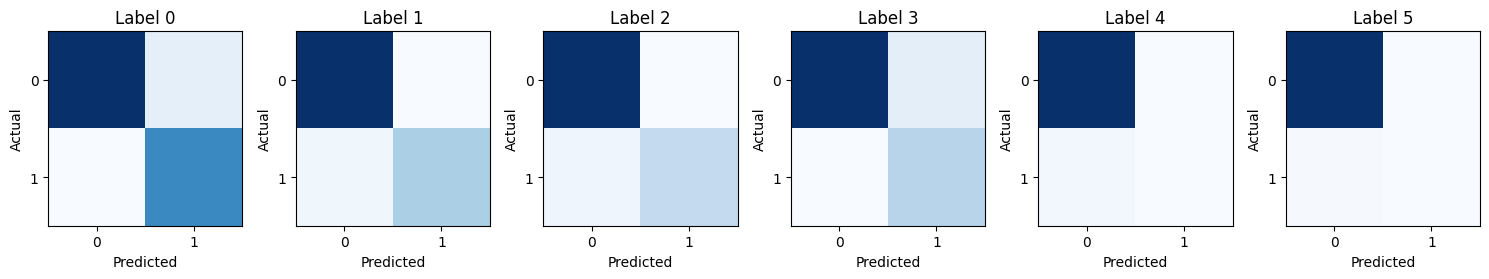

In [24]:
# TFIDF + ClassifierChain
tfidf_chain=ClassifierChainModel(X_train_tfidf, y_train)
tfidf_chain.fit()
y_tfidf_cc=tfidf_chain.predict(X_test_tfidf)
tfidf_chain.test(y_test)

# Model 2: BinaryRelanvenceSVM
### using BOW + BinaryRelanvenceSVM

Exact Match Ratio: 0.6491
Hamming Loss: 0.0779
Recall (Samples): 0.8095
Precision (Samples): 0.8241
F1 Measure (Samples): 0.7990


/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


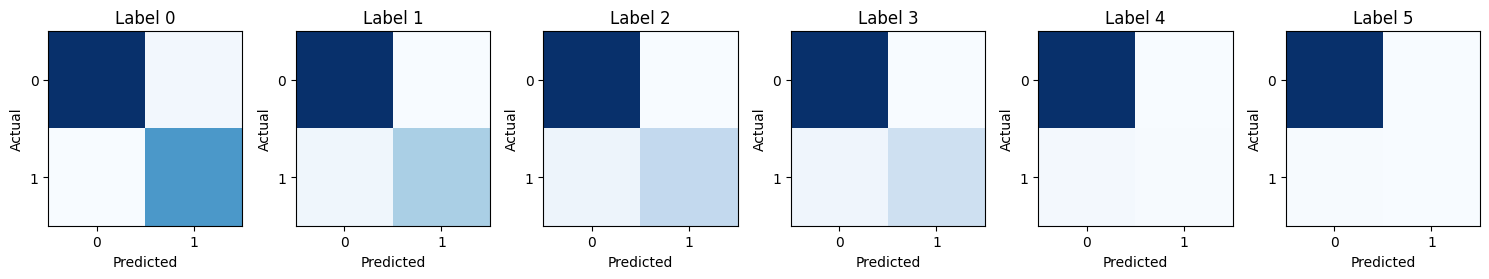

In [25]:
# BOW + BinaryRelanvenceSVM
bow_svm=BinaryRelenvanceSVM(X_train_bow, y_train)
bow_svm.fit()
y_tfidf_cc=bow_svm.predict(X_test_bow)
bow_svm.test(y_test)

# Model 2.1 : Random Forest
### tfidf embeddings with binary relevance Random Forest


Exact Match Ratio: 0.6167
Hamming Loss: 0.0856
Recall (Samples): 0.7740
Precision (Samples): 0.7924
F1 Measure (Samples): 0.7654


/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


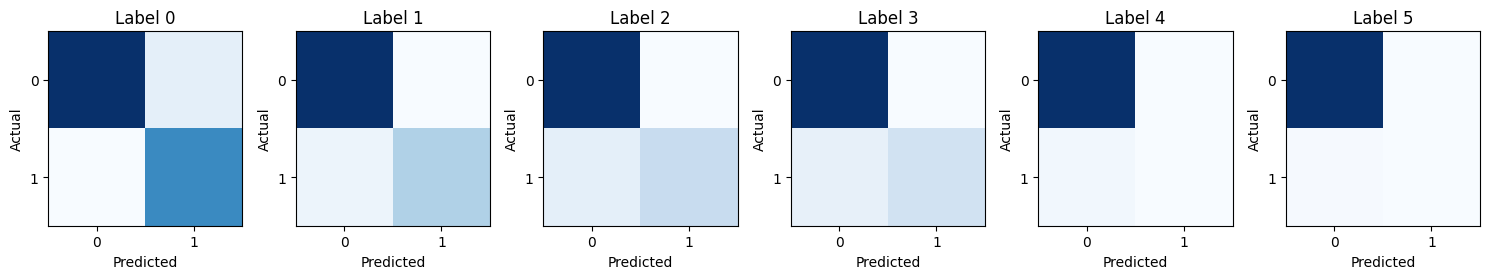

In [26]:
# SVD + TFIDF + BinaryRelenvanceRandomForest
from sklearn.decomposition import TruncatedSVD
# n_components = 1000
# svd = TruncatedSVD(n_components=n_components)
# X_train_tfidf_svd = svd.fit_transform(X_train_tfidf)
# X_test_tfidf = svd.fit_transform(X_test_tfidf)

tfidf_rf=BinaryRelenvanceRandomForest(X_train_tfidf, y_train)
tfidf_rf.fit()
y_tfidf_cc=tfidf_rf.predict(X_test_tfidf)
tfidf_rf.test(y_test)


In [27]:
# # SVD + TFIDF + BinaryRelenvanceRandomForest
# from sklearn.decomposition import TruncatedSVD
# n_components = 100
# svd = TruncatedSVD(n_components=n_components)
# X_train_tfidf_svd = svd.fit_transform(X_train_tfidf)
# X_test_tfidf_svd = svd.fit_transform(X_test_tfidf)

# tfidf_rf=BinaryRelenvanceRandomForest(X_train_tfidf_svd, y_train)
# tfidf_rf.fit()
# y_tfidf_cc=tfidf_rf.predict(X_test_tfidf_svd)
# tfidf_rf.test(y_test)


# Deep Learning


In [57]:
# split data into train, val, test as 50 20 30

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["labels"])

X_train1, X_test_val1, y_train1, y_test_val1 = train_test_split(df["processed_text"], y, test_size=0.5, random_state=42)

X_test1, X_val1, y_test1, y_val1 = train_test_split(X_test_val1, y_test_val1, test_size=0.4, random_state=42)


# Model 3: Bidirectional LSTM
### using word2vec embeddings

In [ ]:

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

def Word2VecModel(X_train):
  # Tokenize the text data
  tokenized_train_texts = [text.split() for text in X_train]
  word2vec_model = Word2Vec(
      sentences=tokenized_train_texts,
      vector_size=100,            # what dimensions should the vector be of
      window=5,                   # Context window size
      min_count=2,
      sg=1                         # Use skip-gram (sg=1)
  )
  return word2vec_model
word2vec_model=Word2VecModel(X_train1)

In [ ]:
# from torch.utils.data import Dataset

# class EmbeddingDataset(Dataset):
#     def __init__(self, textdata,labels,vec_size=100,max_len=100):
#         self.xTrain = textdata
#         self.vec_size=vec_size
#         self.yTrain=labels
#         self.model = word2vec_model
#         self.max_len=max_len

#     def __getitem__(self, idx):
#         text = self.xTrain.iloc[idx]
#         words = text.split()
#         vectorized_words = [self.model.wv[word] for word in words if word in self.model.wv]
#         # if not vectorized_words:
#         #     vectorized_words = [np.zeros(self.vec_size)]

#         # vectorized_words = torch.tensor(vectorized_words, dtype=torch.float32)

#         # if len(vectorized_words) < self.max_len:
#         #     pad_size = self.max_len - len(vectorized_words)
#         #     padding = torch.zeros((pad_size, self.vec_size))
#         #     vectorized_words = torch.cat([vectorized_words, padding], dim=0)
#         # else:
#         #     vectorized_words = vectorized_words[:self.max_len]

#         # currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)

#         # return vectorized_words, currlabel

#         if not vectorized_words:
#           return np.zeros(self.vec_size)
#         currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)

#         return torch.tensor(vectorized_words, dtype=torch.float32), currlabel

#     def __len__(self):
#         return len(self.xTrain)

from torch.utils.data import Dataset
import numpy as np
import torch

class EmbeddingDataset(Dataset):
    def __init__(self, textdata, labels, word2vec_model, vec_size=100, max_len=100):
        self.xTrain = textdata
        self.vec_size = vec_size
        self.yTrain = labels
        self.model = word2vec_model
        self.max_len = max_len

    def __getitem__(self, idx):
        text = self.xTrain.iloc[idx]
        words = text.split()
        vectorized_words = [self.model.wv[word] for word in words if word in self.model.wv]        
        if not vectorized_words:
            vectorized_words = [np.zeros(self.vec_size)]
            
        vectorized_words = torch.tensor(vectorized_words, dtype=torch.float32)
        
        if len(vectorized_words) < self.max_len:
            pad_size = self.max_len - len(vectorized_words)
            padding = torch.zeros((pad_size, self.vec_size))
            vectorized_words = torch.cat([vectorized_words, padding], dim=0)
        else:
            vectorized_words = vectorized_words[:self.max_len]

        currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)

        return vectorized_words, currlabel

    def __len__(self):
        return len(self.xTrain)

train_dataset = EmbeddingDataset(X_train1,y_train1, word2vec_model)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)

val_dataset = EmbeddingDataset(X_val1,y_val1, word2vec_model)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = EmbeddingDataset(X_test1,y_test1, word2vec_model)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [60]:
class BiLSTMClassiferModel(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=128, output_dim=6, num_layers=2):
        super(BiLSTMClassiferModel, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.bilstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        out = self.sigmoid(x)
        return out

In [61]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = BiLSTMClassiferModel(100, 128, 6, 3).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 10

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_train_loss = 0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation Phase
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for X_val, y_val in val_dataloader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            output_val = model(X_val)            
            loss_val = criterion(output_val, y_val)
            total_val_loss += loss_val.item()

    avg_val_loss = total_val_loss / len(val_dataloader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

cuda
Epoch [1/10], Train Loss: 0.4044, Val Loss: 0.3283
Epoch [2/10], Train Loss: 0.2828, Val Loss: 0.2663
Epoch [3/10], Train Loss: 0.2507, Val Loss: 0.2443
Epoch [4/10], Train Loss: 0.2336, Val Loss: 0.2248
Epoch [5/10], Train Loss: 0.2188, Val Loss: 0.2062
Epoch [6/10], Train Loss: 0.2029, Val Loss: 0.2052
Epoch [7/10], Train Loss: 0.1958, Val Loss: 0.2044
Epoch [8/10], Train Loss: 0.1884, Val Loss: 0.2059
Epoch [9/10], Train Loss: 0.1810, Val Loss: 0.2051
Epoch [10/10], Train Loss: 0.1733, Val Loss: 0.2085


In [62]:
import numpy as np

def Results(model, dataloader, criterion,model_name="BiLSTM",type="test", device="none"):
    model.eval()
    total_loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            binary_preds = (outputs > 0.5).cpu().numpy()
            true_labels = targets.cpu().numpy()

            y_pred.append(binary_preds)
            y_true.append(true_labels)

    print(f'{model_name} {type} loss is {total_loss / len(dataloader)}')
    y_pred = np.vstack(y_pred)
    y_true = np.vstack(y_true)
    return y_pred, y_true

BiLSTM train loss is 0.16756225481811093
BiLSTM validation loss is 0.20853365844849384
BiLSTM test loss is 0.2120826868998884
Exact Match Ratio: 0.6838
Hamming Loss: 0.0693
Recall (Samples): 0.8414
Precision (Samples): 0.8507
F1 Measure (Samples): 0.8288


/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


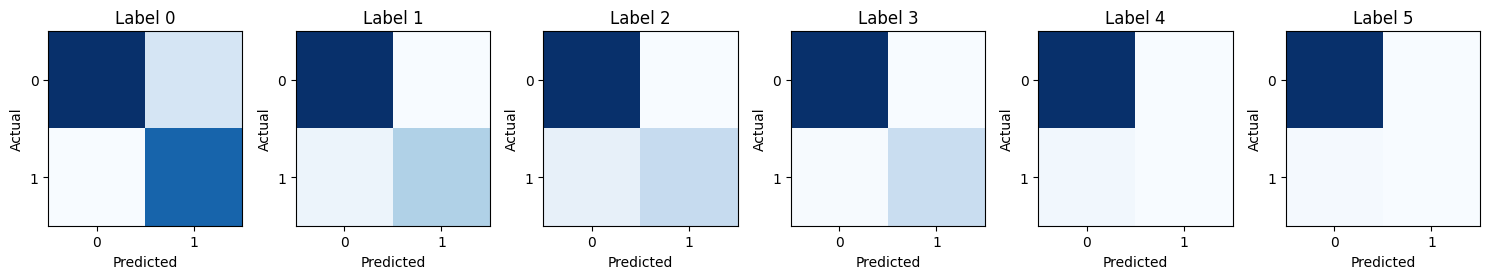

Exact Match Ratio: 0.6360
Hamming Loss: 0.0844
Recall (Samples): 0.8095
Precision (Samples): 0.8162
F1 Measure (Samples): 0.7943


/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


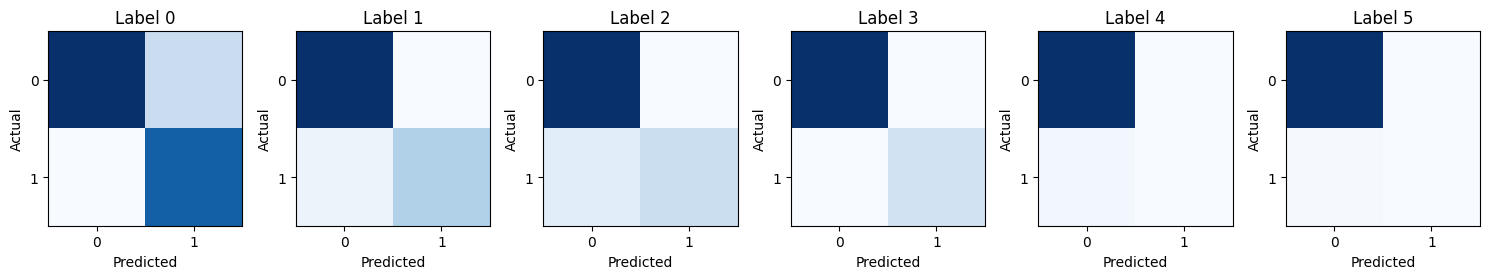

Exact Match Ratio: 0.6379
Hamming Loss: 0.0842
Recall (Samples): 0.8087
Precision (Samples): 0.8196
F1 Measure (Samples): 0.7958


/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


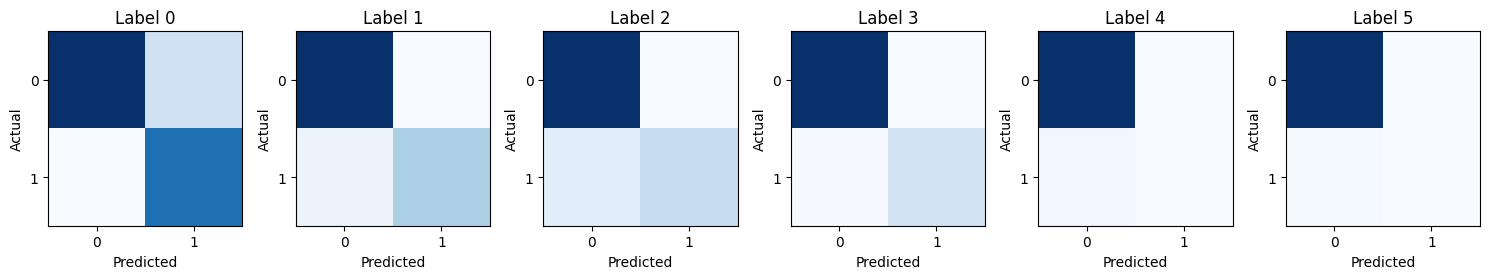

In [64]:
# Run Evaluation
y_train_pred, y_train_true = Results(model, train_dataloader, criterion,model_name="BiLSTM",type="train", device=device)
y_val_pred,y_val_true = Results(model, val_dataloader, criterion,model_name="BiLSTM",type="validation", device=device)
y_test_pred, y_test_true = Results(model, test_dataloader, criterion,model_name="BiLSTM",type="test", device=device)

TestMultiLabel(y_train_true, y_train_pred)
TestMultiLabel(y_val_true, y_val_pred)
TestMultiLabel(y_test_true, y_test_pred)

In [ ]:
# model.eval()
# total_test_loss = 0

# with torch.no_grad():
#     for X_test, y_test in test_dataloader:
#         X_test, y_test = X_test.to(device), y_test.to(device)
#         output_test = model(X_test)
#         loss_test = criterion(output_test, y_test)
#         total_test_loss += loss_test.item()

# avg_test_loss = total_test_loss / len(test_dataloader)
# print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 0.2121


# Model 4: Feed Forward Neural Network
### using sentence average fasttext embeddings

In [69]:
from gensim.models import FastText
from nltk.tokenize import word_tokenize
# Tokenize text into words
train_tokens = X_train.apply(word_tokenize).tolist()

# Train FastText model
fastText_model = FastText(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4)

In [71]:
def get_average_fastText(text, model, vec_size=100):
    words = text.split()
    vectorized_words = [model.wv[word] for word in words if word in model.wv]
    if not vectorized_words:
        return np.zeros(vec_size)
    avg_vector = np.mean(vectorized_words, axis=0)
    return avg_vector

X_train1_fastText = np.array([get_average_fastText(text, word2vec_model, 100) for text in X_train1])
X_val1_fastText = np.array([get_average_fastText(text, word2vec_model, 100) for text in X_val1])
X_test1_fastText = np.array([get_average_fastText(text, word2vec_model, 100) for text in X_test1])

print("fast Text representation shape:", X_train1_fastText.shape)

fast Text representation shape: (10486, 100)


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [75]:

X_train_tensor = torch.tensor(X_train1_fastText, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train1, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val1_fastText, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val1, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test1_fastText, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test1, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [76]:
model_ann = ANNModel(100, 128, 6).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_ann.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model_ann.train()
    total_loss = 0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        output = model_ann(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    model_ann.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_dataloader:
            output_val = model_ann(X_val_batch)
            loss_val = criterion(output_val, y_val_batch)
            total_val_loss += loss_val.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss/len(train_dataloader):.4f}, Val Loss: {total_val_loss/len(val_dataloader):.4f}")

# model_ann.eval()
# total_test_loss = 0
# with torch.no_grad():
#     for X_test_batch, y_test_batch in test_dataloader:
#         output_test = model_ann(X_test_batch)
#         loss_test = criterion(output_test, y_test_batch)
#         total_test_loss += loss_test.item()
# print(f"Final Test Loss: {total_test_loss/len(test_dataloader):.4f}")


Epoch [1/10], Train Loss: 0.3275, Val Loss: 0.2381
Epoch [2/10], Train Loss: 0.2235, Val Loss: 0.2157
Epoch [3/10], Train Loss: 0.2083, Val Loss: 0.2057
Epoch [4/10], Train Loss: 0.2014, Val Loss: 0.2009
Epoch [5/10], Train Loss: 0.1974, Val Loss: 0.1982
Epoch [6/10], Train Loss: 0.1941, Val Loss: 0.1948
Epoch [7/10], Train Loss: 0.1917, Val Loss: 0.1931
Epoch [8/10], Train Loss: 0.1897, Val Loss: 0.1934
Epoch [9/10], Train Loss: 0.1881, Val Loss: 0.1902
Epoch [10/10], Train Loss: 0.1865, Val Loss: 0.1889


ANN train loss is 0.18519005499689317
ANN validation loss is 0.18889877640388228
ANN test loss is 0.18797434193228707
Exact Match Ratio: 0.6634
Hamming Loss: 0.0768
Recall (Samples): 0.8244
Precision (Samples): 0.8358
F1 Measure (Samples): 0.8121


/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


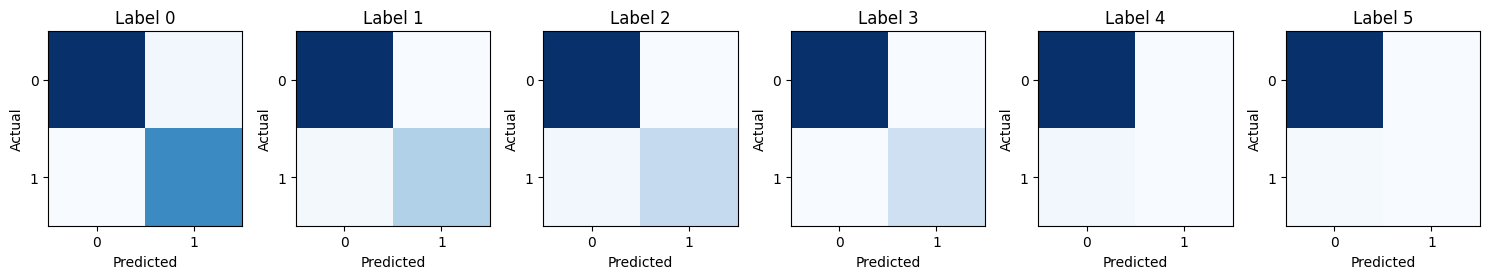

Exact Match Ratio: 0.6636
Hamming Loss: 0.0782
Recall (Samples): 0.8226
Precision (Samples): 0.8377
F1 Measure (Samples): 0.8121


/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


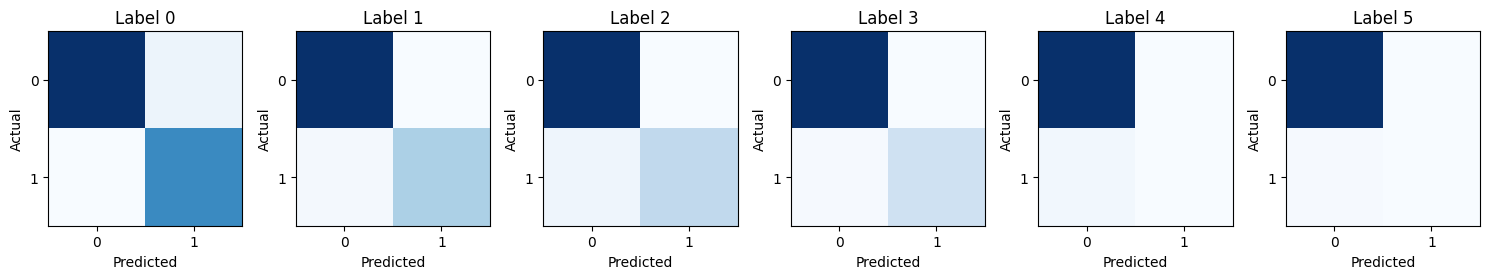

Exact Match Ratio: 0.6621
Hamming Loss: 0.0771
Recall (Samples): 0.8242
Precision (Samples): 0.8398
F1 Measure (Samples): 0.8134


/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


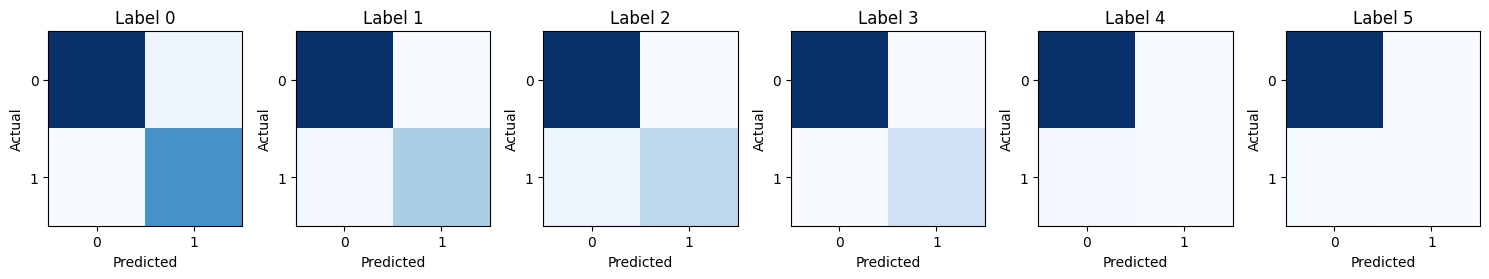

In [77]:
# Run Evaluation
y_train_pred, y_train_true = Results(model_ann, train_dataloader, criterion,model_name="ANN",type="train", device=device)
y_val_pred,y_val_true = Results(model_ann, val_dataloader, criterion,model_name="ANN",type="validation", device=device)
y_test_pred, y_test_true = Results(model_ann, test_dataloader, criterion,model_name="ANN",type="test", device=device)

TestMultiLabel(y_train_true, y_train_pred)
TestMultiLabel(y_val_true, y_val_pred)
TestMultiLabel(y_test_true, y_test_pred)

# Conclusion

## Dataset - 2

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


In [2]:
# Download stopwords if not already available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ai21btech11012/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
file_path = 'sample_data/A2D2.xlsx'
df = pd.read_excel(file_path)
df.head()

,ID,Content,Domain
0,1,engali Binodiini Ekti Natir Putul Chaalchitro ...,Entertainment
1,2,ChiefsAholic A Wolf In Chiefs Clothing articl...,Entertainment
2,3,Kabandha Your Rating Write a review Optional C...,Entertainment
3,4,In Bruges 2008 R 1h 47m IMDb RATING 79 10 474K...,Entertainment
4,5,Men in Black 2012 PG13 1h 46m IMDb RATING 68 1...,Entertainment


In [4]:
# Check for missing values,  class imbalance, and other issues.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3927 entries, 0 to 3926
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       3927 non-null   int64 
 1   Content  3927 non-null   object
 2   Domain   3927 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.2+ KB
None


In [5]:
# Check the unique labels and their counts
df['Domain'].value_counts()

Domain
Technology       1474
Healthcare        913
Entertainment     636
Tourism           562
Sports            342
Name: count, dtype: int64

## Data Preprocessing
Now that we know this is a multi-class classification problem and NOT multi-label classification problem, we :-
1. Use the process_text function defined above for processing text
2. Create and encode labels
3. Split data into train-val-test sets

In [6]:
def process_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    new_processed_text = ' '.join(words)
    return new_processed_text

In [7]:
df["Processed_Content"] = df["Content"].apply(process_text)
df.head()

,ID,Content,Domain,Processed_Content
0,1,engali Binodiini Ekti Natir Putul Chaalchitro ...,Entertainment,engali binodiini ekti natir putul chaalchitro ...
1,2,ChiefsAholic A Wolf In Chiefs Clothing articl...,Entertainment,chiefsaholic wolf chiefs clothing articleshowc...
2,3,Kabandha Your Rating Write a review Optional C...,Entertainment,kabandha rating write review optional characte...
3,4,In Bruges 2008 R 1h 47m IMDb RATING 79 10 474K...,Entertainment,bruges 2008 r 1h 47m imdb rating 79 10 474k ra...
4,5,Men in Black 2012 PG13 1h 46m IMDb RATING 68 1...,Entertainment,men black 2012 pg13 1h 46m imdb rating 68 10 3...


In [8]:
df["Label"] = df["Domain"].astype("category").cat.codes
label_mapping = dict(enumerate(df["Domain"].astype("category").cat.categories))
print(label_mapping)

{0: 'Entertainment', 1: 'Healthcare', 2: 'Sports', 3: 'Technology', 4: 'Tourism'}


In [9]:
# Split into Train and Test sets
train_texts, val_and_test_texts, train_labels, val_and_test_labels = train_test_split(
    df["Processed_Content"], df["Label"], test_size=0.5, random_state=42, stratify=df["Label"]
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    val_and_test_texts, val_and_test_labels, test_size=0.4, random_state=42, stratify=val_and_test_labels
)

In [10]:
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df = pd.DataFrame({"text": val_texts, "label": val_labels})
test_df = pd.DataFrame({"text": test_texts, "label": test_labels})

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 1963, Validation size: 1178, Test size: 786


## Feature extraction/Representation
Convert text data (titles and abstracts) into numerical representations
1. Bag of Words (BoW)
2. TF-IDF (Term Frequency-Inverse Document Frequency)
3. Word Embeddings (Word2Vec, FastText)

- We will be using **TF-IDF** since it is known to work well with text classification using *Classical ML models*.
- Among word embeddings, we would experiment with **Word2Vec** and **FastText** for *Deep Learning models*.

In [100]:
y_test=test_df["label"].values
y_train=train_df["label"].values
y_val=val_df["label"].values

In [95]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["text"])
X_val_tfidf = tfidf_vectorizer.transform(val_df["text"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["text"])

# Print shape to confirm
print("TF-IDF Shape:", X_train_tfidf.shape)

TF-IDF Shape: (1963, 5000)


In [112]:
# Evaluate the model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def EvalMetricsMultiClass(y_true, y_pred, num_classes):
    acc = accuracy_score(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(num_classes)], output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    # print(class_report)

    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    for i in range(num_classes):
        idx=f'Class {i}'
        # print(class_report[idx])
        
        print(f"Class {i}: Precision={class_report[f'Class {i}']['precision']:.2f}, Recall={class_report[f'Class {i}']['recall']:.2f}, F1-score={class_report[f'Class {i}']['f1-score']:.2f}")

    # Confusion Matrix Heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f"Class {i}" for i in range(num_classes)], yticklabels=[f"Class {i}" for i in range(num_classes)])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Per-Class Precision, Recall, F1 Score Bar Chart
    metrics = ["precision", "recall", "f1-score"]
    values = {metric: [class_report[f"Class {i}"][metric] for i in range(num_classes)] for metric in metrics}
    
    x = np.arange(num_classes)
    width = 0.2

    plt.figure(figsize=(5,4))
    for i, metric in enumerate(metrics):
        plt.bar(x + i * width, values[metric], width=width, label=metric)

    plt.xticks(x + width, [f"Class {i}" for i in range(num_classes)])
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.title("Per-Class Precision, Recall, and F1-Score")
    plt.legend()
    plt.show()


# Classical Machine Learning Approach

# Model 1 : Support Vector Classifier (SVC)
### tfidf embeddings+ svc

SVC train accuracy: 1.0
SVC validation accuracy: 0.9991511035653651
SVC test accuracy: 1.0
Accuracy: 1.0000

Classification Report:
Class 0: Precision=1.00, Recall=1.00, F1-score=1.00
Class 1: Precision=1.00, Recall=1.00, F1-score=1.00
Class 2: Precision=1.00, Recall=1.00, F1-score=1.00
Class 3: Precision=1.00, Recall=1.00, F1-score=1.00
Class 4: Precision=1.00, Recall=1.00, F1-score=1.00


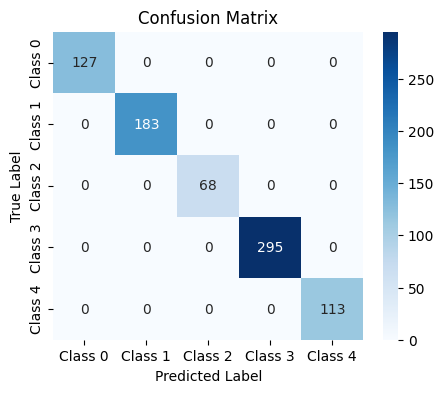

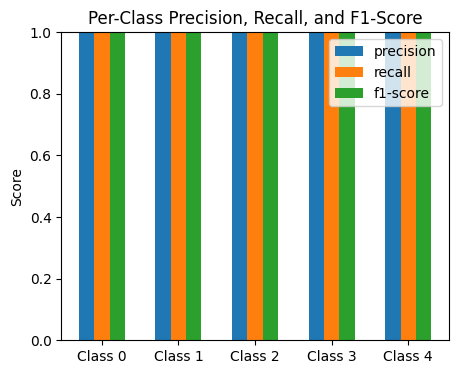

In [113]:
import numpy as np
import pandas as pd
# from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, accuracy_score

class SVCModel():
    def __init__(self, X_train, y_train):
        self.model = SVC(kernel='linear')
        self.X_train = X_train
        self.y_train = y_train

    def fit(self):
        self.model.fit(self.X_train, self.y_train)

    def predict(self, X_test):
        self.y_output = self.model.predict(X_test)
        return self.y_output
    
    def test(self, y_test,type='test'):
        print(f"SVC {type} accuracy:", accuracy_score(y_test, self.y_output))
        # print("Classification Report:")
        # print(classification_report(y_test, self.y_output))


svcModel=SVCModel(X_train_tfidf, y_train)
svcModel.fit()  
y_svc=svcModel.predict(X_train_tfidf)
svcModel.test(y_train,'train')
y_svc=svcModel.predict(X_val_tfidf)
svcModel.test(y_val,'validation')
y_svc=svcModel.predict(X_test_tfidf)
svcModel.test(y_test,'test')


EvalMetricsMultiClass(y_test, y_svc, 5)

# Model 2: Random Forest
### tfidf embeddings with random forest


Random Forest train accuracy: 1.0
Random Forest validation accuracy: 0.9923599320882852
Random Forest test accuracy: 0.9974554707379135
Accuracy: 0.9975

Classification Report:
Class 0: Precision=1.00, Recall=1.00, F1-score=1.00
Class 1: Precision=0.99, Recall=0.99, F1-score=0.99
Class 2: Precision=1.00, Recall=1.00, F1-score=1.00
Class 3: Precision=1.00, Recall=1.00, F1-score=1.00
Class 4: Precision=1.00, Recall=1.00, F1-score=1.00


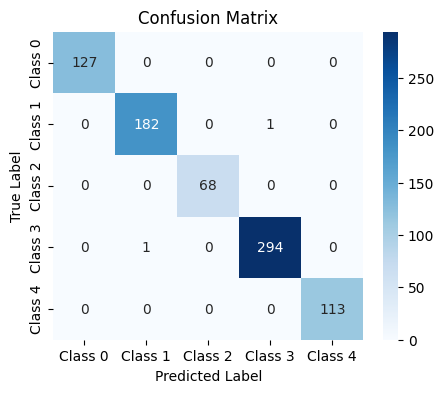

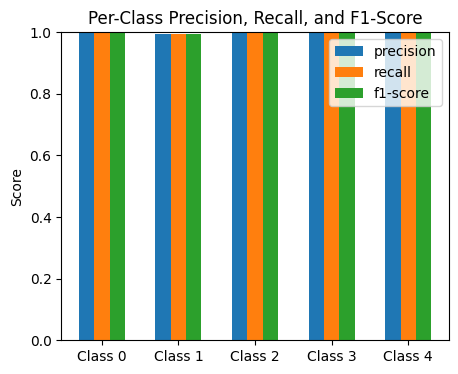

In [114]:

class RandomForestModel():
    def __init__(self, X_train, y_train):
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.X_train = X_train
        self.y_train = y_train

    def fit(self):
        self.model.fit(self.X_train, self.y_train)

    def predict(self, X_test):
        self.y_output = self.model.predict(X_test)
        return self.y_output
    
    def test(self, y_test,type='test'):
        print(f"Random Forest {type} accuracy:", accuracy_score(y_test, self.y_output))
        # print("Classification Report:")
        # print(classification_report(y_test, self.y_output))
        
randomForestModel=RandomForestModel(X_train_tfidf, y_train)
randomForestModel.fit()  
y_randomforest=randomForestModel.predict(X_train_tfidf)
randomForestModel.test(y_train,'train')
y_randomforest=randomForestModel.predict(X_val_tfidf)
randomForestModel.test(y_val,'validation')
y_randomforest=randomForestModel.predict(X_test_tfidf)
randomForestModel.test(y_test,'test')

EvalMetricsMultiClass(y_test, y_randomforest, 5)

# Deep Learning Approach

#### Here we use Word2Vec and FastText Embeddings

In [115]:
def get_average_word2vec(text, model, vector_size=100):
    """
        Convert text into a single averaged word vector.
        Used as input to classical ML models which expects fixed length input

        Args:
        - text (str): Input sentence or document.
        - model (Word2Vec): Trained Word2Vec model.
        - vector_size (int): Size of word vectors.

        Returns:
        - numpy array of shape (vector_size,)
                                                                                """
    tokens = word_tokenize(text)  # Tokenize text
    vectors = [model.wv[word] for word in tokens if word in model.wv]  # Get vectors if word exists
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)  # Average or return zero vector



def get_word_embeddings(text, model, vector_size=100):
    """
    Convert text into a sequence of word embeddings.

        Args:
        - text (str): Input sentence or document.
        - model (Word2Vec): Trained Word2Vec model.
        - vector_size (int): Size of word vectors.

        Returns:
        - List of numpy arrays (each of shape (vector_size,))
                                                                                                    """
    tokens = word_tokenize(text)
    embeddings = [model.wv[word] if word in model.wv else np.zeros(vector_size) for word in tokens]
    return embeddings

In [14]:
!pip install gensim
!pip install scikit-learn

In [13]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ai21btech11012/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [16]:
# !pip uninstall numpy gensim
# !pip install numpy gensim


In [ ]:
from gensim.models import Word2Vec

# Tokenize text into words
train_tokens = train_df["text"].apply(word_tokenize).tolist()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4)

In [117]:
from gensim.models import FastText

# Train FastText model
fasttext_model = FastText(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4)

# Model 3: Feed Forward Neural Network
### averaged sentence word2vec embeddings

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [119]:
def get_average_word2vec(text, model, vec_size=100):
    words = text.split()
    vectorized_words = [model.wv[word] for word in words if word in model.wv]
    if not vectorized_words:
        return np.zeros(vec_size)
    avg_vector = np.mean(vectorized_words, axis=0)
    return avg_vector

X_train2_w2v = np.array([get_average_word2vec(text, word2vec_model, 100) for text in train_texts])
X_val2_w2v = np.array([get_average_word2vec(text, word2vec_model, 100) for text in val_texts])
X_test2_w2v = np.array([get_average_word2vec(text, word2vec_model, 100) for text in test_texts])

print("Word2Vec representation shape:", X_train2_w2v.shape)

Word2Vec representation shape: (1963, 100)


In [120]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train2_w2v, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val2_w2v, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(val_labels.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test2_w2v, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [124]:
model = ANNModel(100, 128, 5)
model = model.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = X_batch.to('cuda:0'), y_batch.to('cuda:0')
        output = model(X_batch)
        y_batch = y_batch.long()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)
    
    train_accuracy = correct_train / total_train

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_dataloader:
            X_val_batch, y_val_batch = X_val_batch.to('cuda:0'), y_val_batch.to('cuda:0')
            output_val = model(X_val_batch)
            y_val_batch = y_val_batch.long()
            loss_val = criterion(output_val, y_val_batch)
            total_val_loss += loss_val.item()
            _, output = torch.max(output_val, 1)
            correct_val += (output == y_val_batch).sum().item()
            total_val += y_val_batch.size(0)
    
    val_accuracy = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()
        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)
        correct_test += (predicted_test == y_test_batch).sum().item()
        total_test += y_test_batch.size(0)

test_accuracy = correct_test / total_test
print(f"Final Test Accuracy: {test_accuracy:.4f}")


Epoch [1/10], Train Acc: 0.7636, Val Acc: 0.9015
Epoch [2/10], Train Acc: 0.9694, Val Acc: 0.9941
Epoch [3/10], Train Acc: 0.9913, Val Acc: 0.9941
Epoch [4/10], Train Acc: 0.9924, Val Acc: 0.9949
Epoch [5/10], Train Acc: 0.9924, Val Acc: 0.9949
Epoch [6/10], Train Acc: 0.9944, Val Acc: 0.9958
Epoch [7/10], Train Acc: 0.9939, Val Acc: 0.9949
Epoch [8/10], Train Acc: 0.9954, Val Acc: 0.9958
Epoch [9/10], Train Acc: 0.9959, Val Acc: 0.9958
Epoch [10/10], Train Acc: 0.9959, Val Acc: 0.9958
Final Test Accuracy: 0.9962


Accuracy: 0.9962

Classification Report:
Class 0: Precision=0.99, Recall=1.00, F1-score=1.00
Class 1: Precision=1.00, Recall=0.99, F1-score=0.99
Class 2: Precision=1.00, Recall=1.00, F1-score=1.00
Class 3: Precision=0.99, Recall=1.00, F1-score=0.99
Class 4: Precision=1.00, Recall=1.00, F1-score=1.00


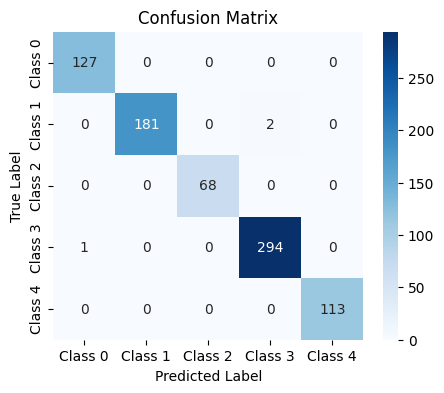

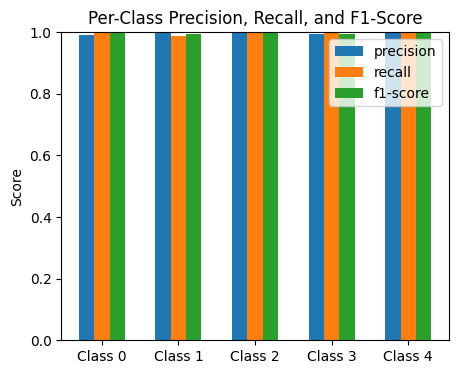

In [125]:
# evaluating model
y_true = []
y_pred = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()
        
        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)
        
        y_true.extend(y_test_batch.cpu().numpy())
        y_pred.extend(predicted_test.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

EvalMetricsMultiClass(y_true, y_pred, num_classes=5)

# Model 4: LSTM
### FastText embeddings

In [ ]:
from torch.utils.data import Dataset

class EmbeddingDataset2(Dataset):
    def __init__(self, textdata,labels,model,vec_size=100,max_len=100):
        self.xTrain = textdata
        self.vec_size=vec_size
        self.yTrain=labels
        self.model = model
        self.max_len=max_len

    def __getitem__(self, idx):
        text = self.xTrain.iloc[idx]
        # print()
        words = text.split()
        vectorized_words = [self.model.wv[word] for word in words if word in self.model.wv]
        if not vectorized_words:
          return np.zeros(self.vec_size)
        currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)

        return torch.tensor(vectorized_words, dtype=torch.float32), currlabel

    def __len__(self):
        return len(self.xTrain)
    
    

train_dataset = EmbeddingDataset2(train_texts, y_train_tensor,fasttext_model)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataset = EmbeddingDataset2(val_texts, y_val_tensor,fasttext_model)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataset = EmbeddingDataset2(test_texts, y_test_tensor,fasttext_model)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [127]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=256, output_dim=5, num_layers=3, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.layer_norm(x)
        x = self.dropout(x)
        out = self.fc(x)
        return out

In [128]:

model = LSTMModel(100,128,5,2)
model = model.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = X_batch.to('cuda:0'), y_batch.to('cuda:0')
        output = model(X_batch)
        y_batch = y_batch.long()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)
    
    train_accuracy = correct_train / total_train

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_dataloader:
            X_val_batch, y_val_batch = X_val_batch.to('cuda:0'), y_val_batch.to('cuda:0')
            output_val = model(X_val_batch)
            y_val_batch = y_val_batch.long()
            loss_val = criterion(output_val, y_val_batch)
            total_val_loss += loss_val.item()
            _, output = torch.max(output_val, 1)
            correct_val += (output == y_val_batch).sum().item()
            total_val += y_val_batch.size(0)
    
    val_accuracy = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()
        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)
        correct_test += (predicted_test == y_test_batch).sum().item()
        total_test += y_test_batch.size(0)

test_accuracy = correct_test / total_test
print(f"Final Test Accuracy: {test_accuracy:.4f}")


/tmp/ipykernel_572221/977243427.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)


Epoch [1/10], Train Acc: 0.8833, Val Acc: 0.9847
Epoch [2/10], Train Acc: 0.9725, Val Acc: 0.9762
Epoch [3/10], Train Acc: 0.9888, Val Acc: 0.9932
Epoch [4/10], Train Acc: 0.9786, Val Acc: 0.9754
Epoch [5/10], Train Acc: 0.9842, Val Acc: 0.9796
Epoch [6/10], Train Acc: 0.9766, Val Acc: 0.9856
Epoch [7/10], Train Acc: 0.9878, Val Acc: 0.9890
Epoch [8/10], Train Acc: 0.9949, Val Acc: 0.9932
Epoch [9/10], Train Acc: 0.9918, Val Acc: 0.9924
Epoch [10/10], Train Acc: 0.9939, Val Acc: 0.9822
Final Test Accuracy: 0.9822


/tmp/ipykernel_572221/977243427.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  currlabel = torch.tensor(self.yTrain[idx], dtype=torch.float32)


Accuracy: 0.9822

Classification Report:
Class 0: Precision=0.97, Recall=0.99, F1-score=0.98
Class 1: Precision=0.99, Recall=0.97, F1-score=0.98
Class 2: Precision=0.95, Recall=0.91, F1-score=0.93
Class 3: Precision=0.98, Recall=1.00, F1-score=0.99
Class 4: Precision=1.00, Recall=1.00, F1-score=1.00


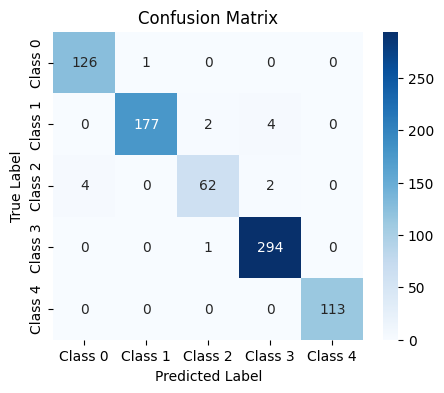

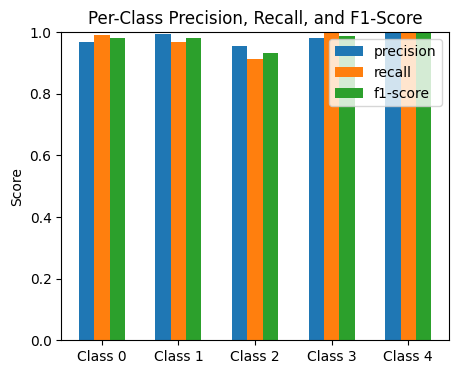

In [129]:
y_true = []
y_pred = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_dataloader:
        X_test_batch, y_test_batch = X_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        y_test_batch = y_test_batch.long()
        
        output_test = model(X_test_batch)
        _, predicted_test = torch.max(output_test, 1)
        
        y_true.extend(y_test_batch.cpu().numpy())
        y_pred.extend(predicted_test.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

EvalMetricsMultiClass(y_true, y_pred, num_classes=5)

# Conclusions